# ある関数のヘッセ行列を求める

$f(x, y)$

$\downarrow$ 一次微分

$grad = [df/dx, df/dy]$

$\downarrow$ 各成分をさらに微分

$\frac{df}{dx} \rightarrow [\frac{d^2f}{dx^2}, \frac{d^2f}{dxdy}]$

$\frac{df}{dy} \rightarrow [\frac{d^2f}{dydx}, \frac{d^2f}{dy^2}]$

$\downarrow$

Hessian行列に格納

In [286]:
import torch

# 変数
"""Info
    - requires_grad=True ... 自動微分可能であることを示す
"""
x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)
params = (x, y)

# 関数
f = x**2 * y + torch.sin(x * y)

# 勾配（一次微分）
"""Info
    - torch.autograd.grad(f, p) ... 関数をpの要素で偏微分する
    - create_graph=True ... 2階微分をとれるように，計算グラフを保持しておく
"""
grad = torch.autograd.grad(f, params, create_graph=True)

# ヘッセ行列初期化
H = torch.zeros(len(params), len(params))

# 二次微分
for i in range(len(params)):
    second = torch.autograd.grad(grad[i], params, retain_graph=True)
    H[i, :] = torch.tensor([s.item() for s in second])

print(H)


tensor([[ 0.3628, -0.2347],
        [-0.2347, -0.9093]])


# ヘッセ行列と勾配でパラメータを更新する（バニラニュートン法の実装）

- 一般にヘッセ行列をそのまま計算するのは愚か．

- 準ニュートン法やBFGS公式による近似を使うことが好まれる．

次の関数

$f(x, y) = x^2 * y + sin(x*y)$

について，
1. $x, y$をランダムに初期化
1. ヘッセ行列と勾配を自動微分
1. ニュートン法で更新

$\mathbf{x}_{t+1}=\mathbf{x}_{t}-H^{-1} \nabla f$

収束まで繰り返し

これは自分用メモ

このタスクにおける目的とLossの意味

- 目的：関数を最小化する底流店を求める

- Lossの意味：現在のパラメータで求めた関数値$f(x, y)$

In [287]:
import torch

EPOCHS = 20
MAX_LOSS = 1e-6

# 初期化関数
def dataset():
    x = torch.randn(1, requires_grad=True)
    y = torch.randn(1, requires_grad=True)
    return (x, y)

# 対象関数 f(x, y) = x^2 * y + sin(xy)
def func(params):
    x, y = params
    return x**2 * y + torch.sin(x * y)

# 初期値
params = dataset()
x, y = params
print(f"param初期値: x={x.item():.4f}, y={y.item():.4f}")

# ニュートン法ループ
for epoch in range(EPOCHS):
    # ① 関数値
    f = func(params)

    # ② 勾配ベクトル ∇f
    grad = torch.autograd.grad(f, params, create_graph=True)
    g = torch.tensor([grad[0].item(), grad[1].item()]).reshape(2, 1)

    # ③ ヘッセ行列 H
    H = torch.zeros(len(params), len(params))
    for i in range(len(params)):
        second = torch.autograd.grad(grad[i], params, retain_graph=True)
        H[i, :] = torch.tensor([s.item() for s in second])

    # ④ ヘッセ行列の逆行列
    try:
        H_inv = torch.inverse(H)
    except RuntimeError:
        print("ヘッセ行列が特異（逆行列が存在しない）です。")
        break

    # ⑤ ニュートン法更新式
    delta = H_inv @ g

    # ⑥ 新しいパラメータの作成（再び requires_grad=True に）
    x_new = torch.tensor(x.item() - delta[0].item(), requires_grad=True)
    y_new = torch.tensor(y.item() - delta[1].item(), requires_grad=True)
    params = (x_new, y_new)
    x, y = params

    # ロス・状態出力
    print(f"epoch={epoch:2d}: x={x.item():.6f}, y={y.item():.6f}, f={f.item():.6f}")

    # ⑦ 収束判定
    if torch.norm(g) < MAX_LOSS:
        print("収束しました。")
        break


param初期値: x=-1.1436, y=0.2922
epoch= 0: x=-1.055807, y=0.059078, f=0.054170
epoch= 1: x=-1.004564, y=0.005634, f=0.003521
epoch= 2: x=-1.000036, y=0.000051, f=0.000026
epoch= 3: x=-1.000000, y=0.000000, f=0.000000
epoch= 4: x=-1.000000, y=0.000000, f=0.000000
収束しました。


# ニューラルネット風に書く

In [288]:
import torch
import matplotlib.pyplot as plt

param初期値: x=0.7019, y=-0.0296
epoch= 0 | f=-0.035370 | x=0.204789 | y=-0.012242
epoch= 1 | f=-0.003020 | x=0.029751 | y=-0.003040
epoch= 2 | f=-0.000093 | x=0.000835 | y=-0.000166
epoch= 3 | f=-0.000000 | x=0.000001 | y=-0.000000
epoch= 4 | f=-0.000000 | x=0.000000 | y=-0.000000
✅ 収束しました。
Loss履歴: [-0.03537045791745186, -0.0030203864444047213, -9.314129420090467e-05, -1.3875066429136496e-07, -1.9270167601372068e-13]


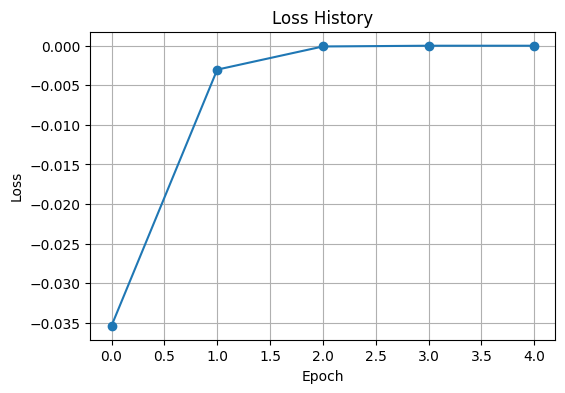

In [289]:
def dataset():
    x = torch.randn(1, requires_grad=True)
    y = torch.randn(1, requires_grad=True)
    return (x, y)

params = dataset()

# 初期値
x, y = params
print(f"param初期値: x={x.item():.4f}, y={y.item():.4f}")

def func(params):
    x, y = params
    return x**2 * y + torch.sin(x * y)

# ニュートン法更新
def update(params):
    x, y = params
    f = func(params)

    # 勾配（1次微分）
    grad = torch.autograd.grad(f, (x, y), create_graph=True)
    g = torch.stack(grad).reshape(2, 1)

    # ヘッセ行列（二次微分）
    H = torch.zeros(2, 2)
    for i in range(2):
        second = torch.autograd.grad(grad[i], (x, y), retain_graph=True)
        H[i, :] = torch.tensor([s.item() for s in second])

    # ヘッセ行列が特異なら更新をスキップ
    try:
        H_inv = torch.inverse(H)
    except RuntimeError:
        print("⚠️ ヘッセ行列が特異（逆行列が存在しない）です。更新を停止します。")
        return params, f, g

    # ニュートンステップ
    delta = H_inv @ g
    x_new = torch.tensor(x.item() - delta[0].item(), requires_grad=True)
    y_new = torch.tensor(y.item() - delta[1].item(), requires_grad=True)

    return (x_new, y_new), f, g

EPOCHS = 100
MAX_LOSS = 1e-6

loss_history = []

for epoch in range(EPOCHS):
    params, f, g = update(params)
    loss_history.append(f.item())

    print(f"epoch={epoch:2d} | f={f.item():.6f} | x={params[0].item():.6f} | y={params[1].item():.6f}")

    # 収束判定（勾配ノルム）
    if torch.norm(g) < MAX_LOSS:
        print("✅ 収束しました。")
        break

print("Loss履歴:", loss_history)

plt.figure(figsize=(6,4))
plt.plot(loss_history, marker='o')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.show()

# 減衰型ニュートン法　VS　SGD

In [301]:
import torch
import torch.optim
import matplotlib.pyplot as plt


初期値: x=-1.8959, y=2.0086
epoch= 0 | f_newton=259.890289 | f_sgd=259.890289
epoch= 1 | f_newton=71.239243 | f_sgd=346.268402
epoch= 2 | f_newton=24.033960 | f_sgd=32.938263
epoch= 3 | f_newton=12.148852 | f_sgd=11.331892
epoch= 4 | f_newton=9.015047 | f_sgd=9.117218
epoch= 5 | f_newton=7.929400 | f_sgd=6.904918
epoch= 6 | f_newton=7.170450 | f_sgd=6.296842
epoch= 7 | f_newton=6.430206 | f_sgd=5.889059
epoch= 8 | f_newton=5.753214 | f_sgd=5.736887
epoch= 9 | f_newton=5.123541 | f_sgd=5.651389
epoch=10 | f_newton=4.543930 | f_sgd=5.614044
epoch=11 | f_newton=4.010659 | f_sgd=5.593886
epoch=12 | f_newton=3.522195 | f_sgd=5.583495
epoch=13 | f_newton=3.076288 | f_sgd=5.577120
epoch=14 | f_newton=2.670927 | f_sgd=5.572785
epoch=15 | f_newton=2.304037 | f_sgd=5.569345
epoch=16 | f_newton=1.973572 | f_sgd=5.566332
epoch=17 | f_newton=1.677491 | f_sgd=5.563513
epoch=18 | f_newton=1.413760 | f_sgd=5.560783
epoch=19 | f_newton=1.180361 | f_sgd=5.558092


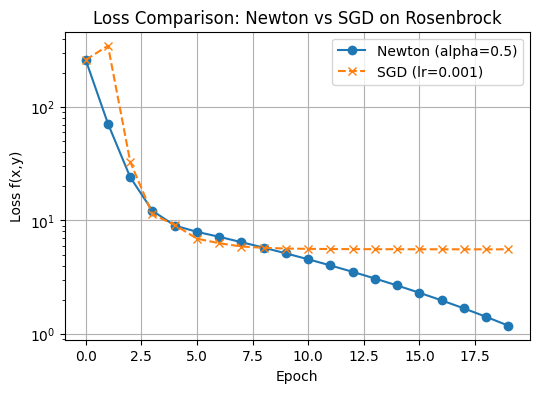

In [309]:
import torch
import matplotlib.pyplot as plt

# ====== 対象関数 ======
def func(params):
    x, y = params
    return (1 - x)**2 + 100*(y - x**2)**2

# ====== データ初期化 ======
def dataset():
    x = torch.empty(1).uniform_(-2, 2).requires_grad_()
    y = torch.empty(1).uniform_(-1, 3).requires_grad_()
    return (x, y)

# ====== ニュートン法更新 ======
def update_newton(params, ALPHA):
    x, y = params
    f = func(params)

    # 勾配（1次微分）
    grad = torch.autograd.grad(f, (x, y), create_graph=True)
    g = torch.stack(grad).reshape(2, 1)

    # ヘッセ行列（二次微分）
    H = torch.zeros(2, 2)
    for i in range(2):
        second = torch.autograd.grad(grad[i], (x, y), retain_graph=True)
        H[i, :] = torch.tensor([s.item() for s in second])

    # 逆行列計算
    try:
        H_inv = torch.inverse(H)
    except RuntimeError:
        print("⚠️ ヘッセ行列が特異（逆行列が存在しない）です。更新停止。")
        return params, f, g

    # 減衰付きニュートンステップ
    delta = H_inv @ g
    x_new = torch.tensor(x.item() - ALPHA * delta[0].item(), requires_grad=True)
    y_new = torch.tensor(y.item() - ALPHA * delta[1].item(), requires_grad=True)

    return (x_new, y_new), f, g

# ====== SGD更新 ======
def update_sgd(params, LR):
    x, y = params
    f = func(params)
    f.backward()

    with torch.no_grad():
        x_new = torch.tensor(x.item() - LR * x.grad.item(), requires_grad=True)
        y_new = torch.tensor(y.item() - LR * y.grad.item(), requires_grad=True)

    x.grad = None
    y.grad = None
    return (x_new, y_new), f


# ====== トレーニング設定 ======
EPOCHS = 20
LR = 0.001  # SGDの学習率をかなり小さくしないと発散する
ALPHA = 0.5

# ====== 初期化 ======
params_newton = dataset()
params_sgd = (torch.clone(params_newton[0]).detach().requires_grad_(True),
              torch.clone(params_newton[1]).detach().requires_grad_(True))

loss_history_newton = []
loss_history_sgd = []

print(f"初期値: x={params_newton[0].item():.4f}, y={params_newton[1].item():.4f}")

# ====== ループ ======
for epoch in range(EPOCHS):
    # Newton
    params_newton, f_newton, g = update_newton(params_newton, ALPHA)
    loss_history_newton.append(f_newton.item())

    # SGD
    params_sgd, f_sgd = update_sgd(params_sgd, LR)
    loss_history_sgd.append(f_sgd.item())

    print(f"epoch={epoch:2d} | f_newton={f_newton.item():.6f} | f_sgd={f_sgd.item():.6f}")

    if torch.norm(g) < 1e-6:
        print("✅ 収束しました（Newton）")
        break

# ====== プロット ======
plt.figure(figsize=(6,4))
plt.plot(loss_history_newton, 'o-', label=f'Newton (alpha={ALPHA})')
plt.plot(loss_history_sgd, 'x--', label=f'SGD (lr={LR})')
plt.title('Loss Comparison: Newton vs SGD on Rosenbrock')
plt.xlabel('Epoch')
plt.ylabel('Loss f(x,y)')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()
